In [15]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

%matplotlib inline

In [4]:
data = pd.read_csv(filepath_or_buffer="../data/BTC", index_col="Date")

In [5]:
data.head()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2014-01-07,874.67040,892.06753,810.00000,810.00000,15.622378,13151.472844,841.835522
2014-01-08,810.00000,899.84281,788.00000,824.98287,19.182756,16097.329584,839.156269
2014-01-09,825.56345,870.00000,807.42084,841.86934,8.158335,6784.249982,831.572913
2014-01-10,839.99000,857.34056,817.00000,857.33056,8.024510,6780.220188,844.938794
2014-01-11,858.20000,918.05471,857.16554,899.84105,18.748285,16698.566929,890.671709


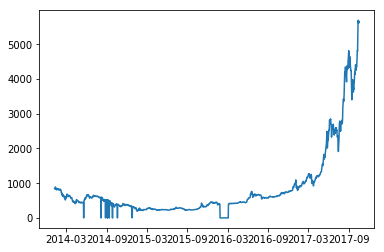

In [28]:
plt.plot(pd.to_datetime(data.index), data['Weighted Price'])

In [30]:
data.describe()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
count,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1.380000e+03,1380.000000
mean,827.265139,852.988287,802.438957,830.701189,1426.416562,3.029182e+06,828.080762
std,983.650668,1020.690227,949.973148,991.896300,2590.887536,7.708946e+06,985.386001
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,296.991870,314.654758,289.275325,299.996087,12.010152,4.718961e+03,299.770053
50%,501.218380,524.877745,487.447500,504.612380,107.340420,3.150177e+04,499.415896
75%,769.581250,777.170500,758.340250,768.466000,1573.900464,1.097462e+06,767.736584
max,5800.000000,5854.400000,5556.100000,5800.000000,21846.766955,7.435428e+07,5692.831135


In [33]:
data.isnull().sum(axis=0)

Open                 0
High                 0
Low                  0
Close                0
Volume (BTC)         0
Volume (Currency)    0
Weighted Price       0
dtype: int64

In [40]:
# We have 48 values with 0
data['Weighted Price'].apply(lambda x:x==0).sum()

48

In [45]:
# Replace that with NA
data['Weighted Price'].replace(0, np.nan, inplace=True)
data['Weighted Price'].isnull().sum()

48

In [46]:
# propagate last valid observation forward to next valid backfill
data['Weighted Price'].fillna(method='ffill', inplace=True)

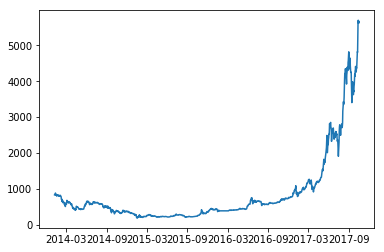

In [47]:
plt.plot(pd.to_datetime(data.index), data['Weighted Price'])

In [128]:
from sklearn.preprocessing import MinMaxScaler
values = data['Weighted Price'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [129]:
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))

965 415


In [130]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [131]:
look_back = 2
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

963
413


In [132]:
train[0:5]

array([[ 0.11690941],
       [ 0.11642168],
       [ 0.11504118],
       [ 0.11747435],
       [ 0.12579972]], dtype=float32)

In [133]:
trainX[0:5]

array([[ 0.11690941,  0.11642168],
       [ 0.11642168,  0.11504118],
       [ 0.11504118,  0.11747435],
       [ 0.11747435,  0.12579972],
       [ 0.12579972,  0.12029894]], dtype=float32)

In [134]:
trainY[0:5]

array([ 0.11504118,  0.11747435,  0.12579972,  0.12029894,  0.11516626], dtype=float32)

In [135]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [136]:
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=20, batch_size=100, 
                    validation_data=(testX, testY), verbose=0, shuffle=False)

In [137]:
yhat_test = model.predict(testX)
yhat_train =  model.predict(trainX)

In [138]:
z = pd.to_datetime(data.index)
k = z.tolist()

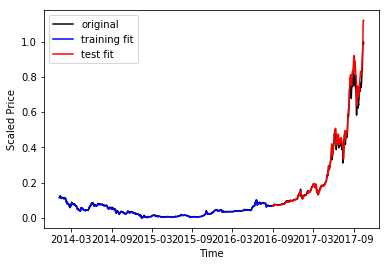

In [139]:
plt.plot(k, scaled, c='k')
plt.plot(k[0:len(yhat_train)], yhat_train, c='b')
plt.plot(k[-len(yhat_test):], yhat_test, c='r')
plt.xlabel('Time')
plt.ylabel('Scaled Price')
plt.legend(['original', 'training fit', 'test fit'])
plt.show()